# Regresión logística

La idea de este notebook es realizar una predicción mediante regresión logística utilizando los preprocessings:
* Standard preprocessing parte 1
* Preprocessing significantes 90% de varianza explicada
* Primeras variables seleccionadas por un árbol de decisión.

In [32]:
# Modelo
from sklearn.linear_model import LogisticRegression

# Preprocessing
from preprocessing import standard_preprocessing_base_parte_1, preprocessing_significantes, preprocessing_mejores_por_arbol
import utils
from sklearn.preprocessing import StandardScaler

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

ImportError: cannot import name 'preprocessing_mejores_por_arbol' from 'preprocessing' (/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py)

In [2]:
df = utils.get_data()

## Modelo 1 - Standard Preprocessing parte 1

Será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

A las que se les aplicará una función de Standarización para que la regresión logísitca y su regularización funcionen correctamente.

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112)

X_train_1, X_test_1 = standard_preprocessing_base_parte_1(X_train_1, X_test_1)

In [4]:
model = LogisticRegression()
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 3, 13), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=4, cv=10)

In [5]:
gscv1.fit(X_train_1, y_train_1)

Fitting 10 folds for each of 143 candidates, totalling 1430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1430 out of 1430 | elapsed:   38.2s finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': array([1.00000000e-03, 3.1622...
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', ver

In [6]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv1.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv1.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'C': 0.03162277660168379, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Con un Score (RocAUC) de:  0.8805


Realicemos ahora el modelo por fuera del gridSearch

In [7]:
lr1 = gscv1.best_estimator_

In [8]:
lr1.fit(X_train_1, y_train_1)

LogisticRegression(C=0.03162277660168379, l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')

In [9]:
print(classification_report(y_test_1,lr1.predict(X_test_1)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6182
           1       0.72      0.52      0.60      1959

    accuracy                           0.84      8141
   macro avg       0.79      0.73      0.75      8141
weighted avg       0.83      0.84      0.83      8141



Vemos que el modelo tiene un accuracy de 84%. Un recall común para los ceros, un poco pobre para los unos, esto se verá reflejado en la matriz de confusión

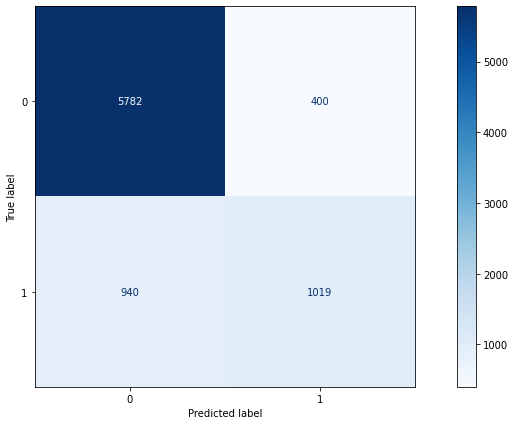

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(lr1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos aquí que hay muchos Falsos negativos, es decir que el modelo no está pudiendo predecir correctamente a los unos.

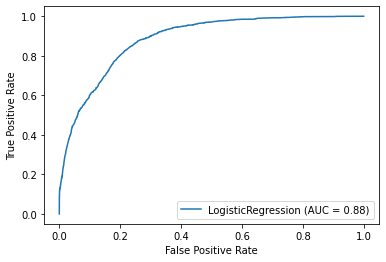

In [11]:
plot_roc_curve(lr1, X_test_1, y_test_1)

In [12]:
roc_auc_score(y_test_1, lr1.predict_proba(X_test_1)[:,1])

0.8836616094181777

Vemos que el RocAUC fue de 0.88, por lo que estamos frente a un modelo decente, pero definitivamente no el mejor.

## Modelo 2 - Preprocessing Significantes 90% varianza explicada

Queremos ver ahora cómo actúa la regresión logística con las variables proyectadas por PCA con 90% de la varianza explicada.


In [17]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, 0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [22]:
model = LogisticRegression()
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 3, 7), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 3, 7), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 3, 7), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv2 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=4, cv=10)

In [23]:
gscv2.fit(X_train_2, y_train_2)

Fitting 10 folds for each of 77 candidates, totalling 770 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:  6.9min finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=4)

In [24]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv2.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv2.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'C': 0.01, 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}
Con un Score (RocAUC) de:  0.8833


In [25]:
lr2 = gscv2.best_estimator_

In [26]:
lr2.fit(X_train_2, y_train_2)

LogisticRegression(C=0.01, l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [27]:
print(classification_report(y_test_2,lr2.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6182
           1       0.70      0.54      0.61      1959

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.83      8141



Vemos que el modelo obtenido posee métricas similares al anterior modelo.

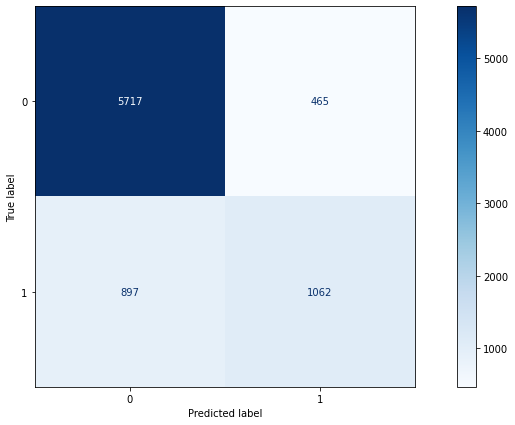

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(lr2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

La matriz de confusión tamibén es similar a la obtenida por el modelo anterior

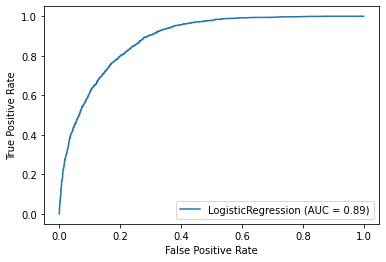

In [29]:
plot_roc_curve(lr2, X_test_2, y_test_2)

In [30]:
roc_auc_score(y_test_2, lr2.predict_proba(X_test_2)[:,1])

0.8866545813241327

La curva ROC y su puntuación AUC son decentes, pero podemos ver que no se trata del mejor modelo.

## Modelo 3 - mejores variables del árbol

In [ ]:
gscv.best_params_

In [ ]:
df = utils.get_data()

In [ ]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)
X_train, X_test = preprocessing.preprocessing_4_mejores_variables_arbol(X_train, X_test)

### El árbol de decisión. Veamos qué variables elegimos

In [ ]:
import graphviz
import dtreeviz.trees as dtreeviz

In [ ]:
arbol = DecisionTreeClassifier(min_samples_leaf=300, max_depth=5, random_state=27)
arbol.fit(X_train, y_train)

In [ ]:
viz = dtreeviz.dtreeviz(
    arbol,
    X_train,
    y_train,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

##### Variables seleccionadas:
(La selección la hacemos nosotors mirando las ganancias en separación con los pieplots)

* Rol familiar registrado.
* Años estudiados.
* ganancia/perdida declarada en la bolsa.
* Edad.
* horas de trabajo registradas.

Por lo que se usarán dichas variables para realizar la regresión, además se escalarán para poder aplicar regularización.

In [ ]:
df['horas_trabajo_registradas']

In [ ]:
def filtrar_variables(X):
    seleccion = ['rol_familiar_registrado_casado', 'anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina', 'edad', 'horas_trabajo_registradas']
    return X[seleccion]

In [ ]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
X = filtrar_variables(X)
Y = df['tiene_alto_valor_adquisitivo']

# El mismo random_state nos asegura no estar provocando un leaking al seleccionar las variables.
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

## Entrenamiento del modelo

##### Primero se escalan las features

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train = pd.DataFrame(scaler.fit_transform(X_train)).set_axis(X_train.columns, axis=1)
X_test = pd.DataFrame(scaler.transform(X_test)).set_axis(X_train.columns, axis=1)

##### Búsqueda de hiperparámetros con KFoldCV

In [ ]:
model = LogisticRegression(n_jobs=-1, random_state=27)
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 2, 6), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 2, 6), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 2, 6), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

In [ ]:
gscv.fit(X_train, y_train)

In [ ]:
print(gscv.best_estimator_)
print(gscv.best_params_)
print(gscv.best_score_)

In [ ]:
print(classification_report(y_test,gscv.predict(X_test)))

##### El modelo

In [ ]:
modelo = gscv.best_estimator_

modelo.fit(X_train, y_train)

In [ ]:
modelo.coef_

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_roc_curve(modelo, X_test, y_test, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(modelo, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.show()